##### Scope
1. Fitting ensamble model on data to predict if the given individual is likely to earn more than 50,000. 
2. Fitting random forest model on data to predict if the given individual is likely to earn more than 50,000. 
3. Fitting gradient boosting model on data to predict if the given individual is likely to earn more than 50,000. 

#### Data load and initial data prep

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [2]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop(["SalStat", "nativecountry", "race"], axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

## 1. Simple Ensemble



##### 1.1. Standardization and fitting LR, KN and decision tree models

In [3]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [4]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1, penalty="l2", solver="saga", max_iter=1000)

lr = logreg.fit(X_train_std, y_train)

print(f"Train Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Train Accuracy: 0.8507153467281683
Test Accuracy: 0.8555347091932458


In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_std, y_train)

print(f"Train Accuracy: {knn.score(X_train_std, y_train)}")
print(f"Test Accuracy: {knn.score(X_test_std, y_test)}")

Train Accuracy: 0.8463763583769838
Test Accuracy: 0.8358348968105066


In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=25)

dt.fit(X_train_std, y_train)

print(f"Train Accuracy: {dt.score(X_train_std, y_train)}")
print(f"Test Accuracy: {dt.score(X_test_std, y_test)}")

Train Accuracy: 0.8614650926432648
Test Accuracy: 0.8610068792995622


##### 1.2. VotingClassifier to ensamble the models

In [7]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)],
    voting='hard'
)

model.fit(X_train_std, y_train)

print(f"Acc. score train: {model.score(X_train_std, y_train)}")
print(f"Acc. score test: {model.score(X_test_std, y_test)}")

Acc. score train: 0.8597451332968493
Acc. score test: 0.8595997498436523


In [8]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)],
    voting='soft'
)

model.fit(X_train_std, y_train)

print(f"Acc. score train: {model.score(X_train_std, y_train)}")
print(f"Acc. score test: {model.score(X_test_std, y_test)}")

Acc. score train: 0.8627941521382222
Acc. score test: 0.8622576610381488


## 2. Random Forest



##### 2.1. Random Forest model fit using the default hyperparameters


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2024)

rf.fit(X_train_std, y_train)

print(f"Acc. score train: {rf.score(X_train_std, y_train)}")
print(f"Acc. score test: {rf.score(X_test_std, y_test)}")

Acc. score train: 0.9737315299820186
Acc. score test: 0.8466228893058161


In [10]:
y_probs_untuned = rf.predict_proba(X_train_std)[:,1]
y_probs_test_untuned = rf.predict_proba(X_test_std)[:,1]

In [11]:
importance_df = (
    pd.DataFrame({
        'features': X_train.columns,
        'importance': rf.feature_importances_
                }).sort_values('importance', ascending=False)
)

importance_df

,features,importance
0,age,0.250510
3,hoursperweek,0.121911
1,capitalgain,0.114212
27,maritalstatus_ Married-civ-spouse,0.104430
2,capitalloss,0.040603
29,maritalstatus_ Never-married,0.036289
40,occupation_ Prof-specialty,0.024716
34,occupation_ Exec-managerial,0.024211
19,EdType_ Bachelors,0.023301
50,gender_ Male,0.021353


##### 2.2. Random Search hyperparameter tuning

In [12]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=2024, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'max_features': [None, 'sqrt'],
    'bootstrap': [True, False],
    'max_samples': [None, 0.3, 0.5, 0.9],
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

grid = RandomizedSearchCV(
    rf,
    params,
    n_iter=100,
    scoring='accuracy'
)

# grid.fit(X_train, y_train)

# best_search_results = grid.best_params_
best_search_results = {
    'n_estimators': 600,
    'min_samples_leaf': 2,
    'max_samples': 0.9,
    'max_features': None,
    'max_depth': 9,
    'bootstrap': True
}

{'n_estimators': 600,
 'min_samples_leaf': 2,
 'max_samples': 0.9,
 'max_features': None,
 'max_depth': 9,
 'bootstrap': True}

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_tuned = RandomForestClassifier(random_state=2024, **best_search_results)

rf_tuned.fit(X_train_std, y_train)

print(f"Acc. score train: {rf_tuned.score(X_train_std, y_train)}")
print(f"Acc. score test: {rf_tuned.score(X_test_std, y_test)}")

Acc. score train: 0.8701821593307795
Acc. score test: 0.8678861788617886


In [14]:
y_probs_tuned = rf_tuned.predict_proba(X_train_std)[:,1]
y_probs_test_rf_tuned = rf_tuned.predict_proba(X_test_std)[:,1]

In [15]:
def show_roc_curve(y_train, y_probs):
    from sklearn.metrics import roc_curve, auc
    
    # ROC 
    fpr, tpr, thresholds = roc_curve(y_train, y_probs)
    
    auc_score = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Model (AUC = {auc_score:.2f})')
    
    # Draw random guess line
    plt.plot([0,1], [0,1], 'k--', label='Random Guess (AUC = 0.50)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend()
    plt.show()

##### 2.3. ROC Curves and AUCs comparison

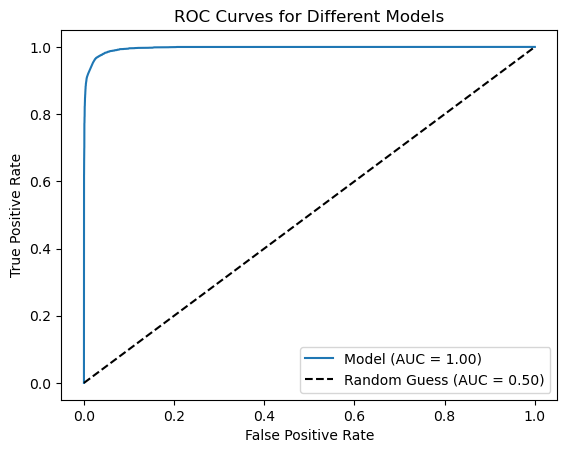

In [16]:
show_roc_curve(y_train, y_probs_untuned)

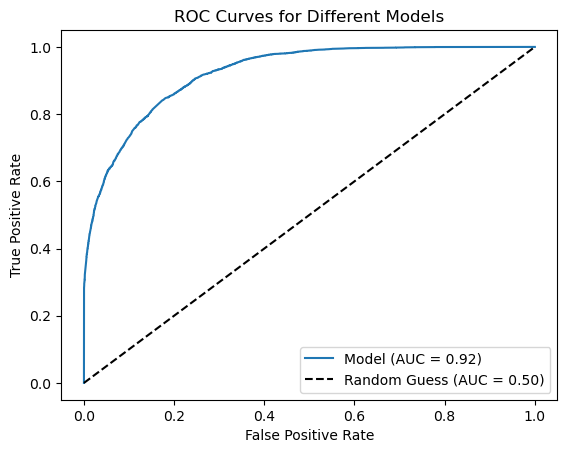

In [17]:
show_roc_curve(y_train, y_probs_tuned)

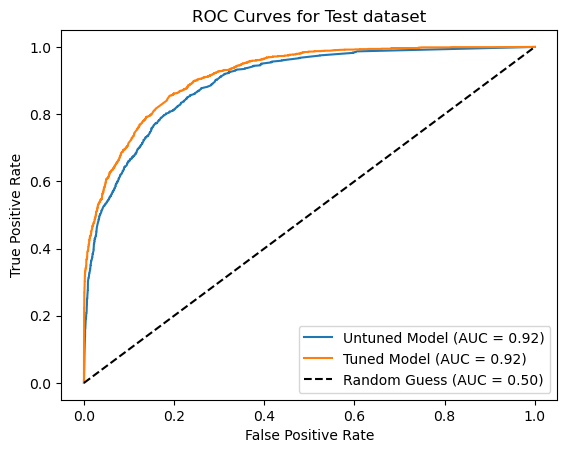

In [18]:
def compare_roc_curves(y_train, y_probs_untuned, y_probs_tuned):
    from sklearn.metrics import roc_curve, auc
    
    # ROC 
    untuned_fpr, untuned_tpr, thresholds = roc_curve(y_train, y_probs_untuned)
    tuned_fpr, tuned_tpr, thresholds = roc_curve(y_train, y_probs_tuned)
    
    untuned_auc_score = auc(untuned_fpr, untuned_tpr)
    auc_score = auc(tuned_fpr, tuned_tpr)    
    
    plt.plot(untuned_fpr, untuned_tpr, label=f'Untuned Model (AUC = {auc_score:.2f})')
    plt.plot(tuned_fpr, tuned_tpr, label=f'Tuned Model (AUC = {auc_score:.2f})')
    # Draw random guess line
    plt.plot([0,1], [0,1], 'k--', label='Random Guess (AUC = 0.50)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Test dataset')
    plt.legend()
    plt.show()

compare_roc_curves(y_test, y_probs_test_untuned, y_probs_test_rf_tuned)

## 3. Gradient Boosting



##### 3.1. Fit and Tune a GBM

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=2024)

gbm.fit(X_train_std, y_train)

print(f"Acc. score train: {gbm.score(X_train_std, y_train)}")
print(f"Acc. score test: {gbm.score(X_test_std, y_test)}")

Acc. score train: 0.8665858806973653
Acc. score test: 0.8685115697310819


In [20]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': np.arange(start=20, stop=200, step=5),
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_features': [None, 'sqrt'],
    'subsample': [0.8, 0.9, 1.0],
    'max_depth': np.arange(start=3, stop=12, step=2),
    'min_samples_leaf': [2, 5, 10]
}

grid = RandomizedSearchCV(
    gbm,
    params,
    n_iter=100,
    scoring='accuracy'
)

#grid.fit(X_train_std, y_train)

#best_search_results = grid.best_params_

best_search_results = {
    'subsample': 1.0,
    'n_estimators': 160,
    'min_samples_leaf': 2,
    'max_features': None,
    'max_depth': 3,
    'learning_rate': 0.2
}

In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': np.arange(start=150, stop=170, step=3),
    'learning_rate': [0.2, 0.3, 0.4],
    'max_features': [None, 'sqrt'],
    'subsample': [0.9, 1.0],
    'max_depth': np.arange(start=1, stop=3, step=2),
    'min_samples_leaf': [2,]
}

grid = GridSearchCV(
    gbm,
    params,
    scoring='accuracy'
)

# grid.fit(X_train_std, y_train)

# grid.best_params_

best_search_results = {
    'learning_rate': 0.4,
    'max_depth': 1,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'n_estimators': 165,
    'subsample': 1.0
}

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_tuned = GradientBoostingClassifier(random_state=2024, **best_search_results)

gbm_tuned.fit(X_train_std, y_train)

print(f"Acc. score train: {gbm.score(X_train_std, y_train)}")
print(f"Acc. score test: {gbm.score(X_test_std, y_test)}")

Acc. score train: 0.8665858806973653
Acc. score test: 0.8685115697310819


In [23]:
y_probs_tuned = gbm_tuned.predict_proba(X_train_std)[:,1]
y_probs_test_gbm_tuned = gbm_tuned.predict_proba(X_test_std)[:,1]

##### 3.2. Plot Feature Importance for the Tuned GBM

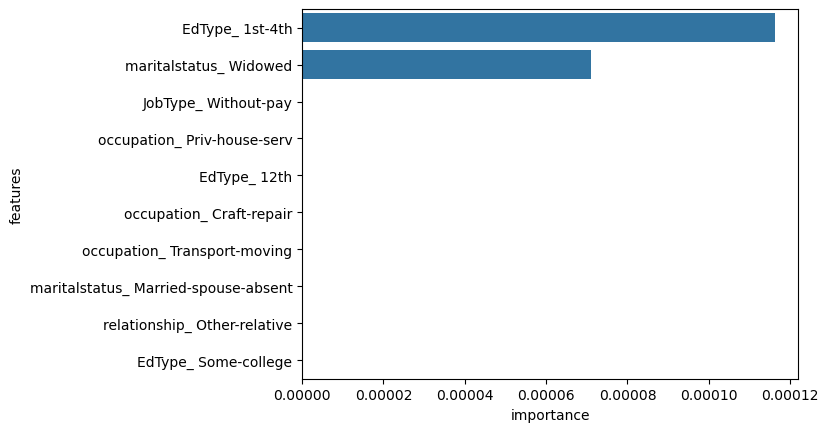

In [24]:
importance_df = (
    pd.DataFrame({
        'features': X_train.columns,
        'importance': gbm.feature_importances_
                }).sort_values('importance', ascending=False)
)

sns.barplot(data=importance_df[-10:], x='importance', y='features');

##### 3.3. Tuned GBM ROC curve vs your tuned Random Forest model

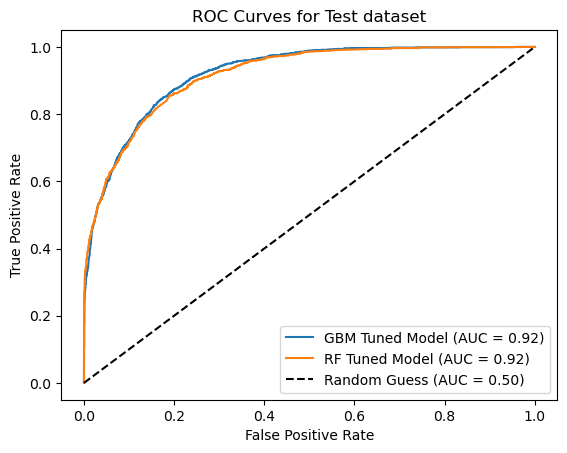

In [25]:
def compare_roc_curves(y_train, y_probs_1, model_name_1, y_probs_2, model_name_2):
    from sklearn.metrics import roc_curve, auc
    
    # ROC 
    untuned_fpr, untuned_tpr, thresholds = roc_curve(y_train, y_probs_1)
    tuned_fpr, tuned_tpr, thresholds = roc_curve(y_train, y_probs_2)
    
    untuned_auc_score = auc(untuned_fpr, untuned_tpr)
    auc_score = auc(tuned_fpr, tuned_tpr)    
    
    plt.plot(untuned_fpr, untuned_tpr, label=f'{model_name_1} Model (AUC = {auc_score:.2f})')
    plt.plot(tuned_fpr, tuned_tpr, label=f'{model_name_2} Model (AUC = {auc_score:.2f})')
    # Draw random guess line
    plt.plot([0,1], [0,1], 'k--', label='Random Guess (AUC = 0.50)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Test dataset')
    plt.legend()
    plt.show()

compare_roc_curves(y_test, y_probs_test_gbm_tuned, 'GBM Tuned', y_probs_test_rf_tuned, 'RF Tuned')

In [26]:
for col in X_test.select_dtypes("bool"):
    X_test[col] = X_test[col].astype('int')


##### 3.4. Shap values explaining the model outcomes

In [27]:
import shap

explainer = shap.Explainer(gbm)

shap_values = explainer.shap_values(X_train.sample(50, random_state=2024))

shap_obj = explainer(X_test)

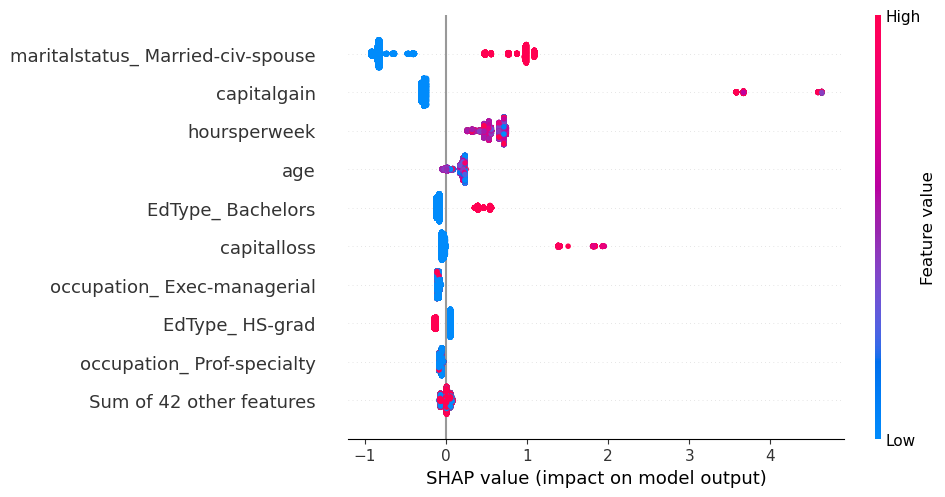

In [28]:
shap.plots.beeswarm(shap_obj)

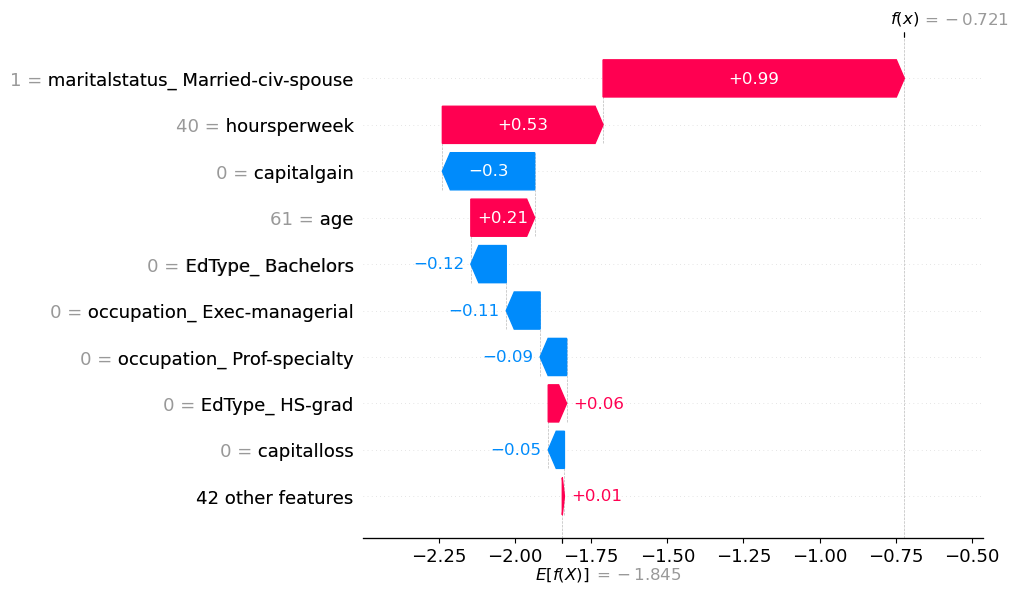

In [29]:
shap.plots.waterfall(shap_obj[30])